In [42]:
from utils import RAW_DATA_DIR
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Make sure to download stopwords if you haven't already:
# nltk.download('stopwords')

In [28]:
df = pd.read_csv(RAW_DATA_DIR / "spam_assassin.csv")
vec = CountVectorizer()
df.head()

,id,mail,category,spam
0,00001.1a31cc283af0060967a233d26548a6ce,Return-Path: <exmh-workers-admin@spamassassin....,easy_ham_2,0
1,00001.317e78fa8ee2f54cd4890fdc09ba8176,From ilug-admin@linux.ie Tue Aug 6 11:51:02 ...,spam_2,1
2,00001.7848dde101aa985090474a91ec93fcf0,From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...,spam,1
3,00001.7c53336b37003a9286aba55d2945844c,From exmh-workers-admin@redhat.com Thu Aug 22...,easy_ham,0
4,00001.7c7d6921e671bbe18ebb5f893cd9bb35,Return-Path: Fool@motleyfool.com\nDelivery-Dat...,hard_ham,0


2025-04-02 16:59:54,997 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-02 16:59:55,002 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Dystrybucja klas')

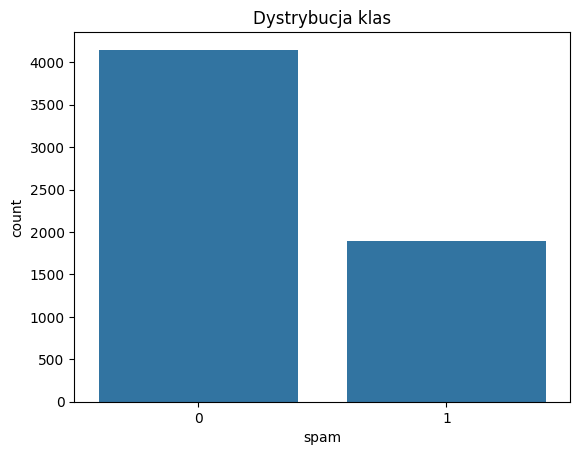

In [40]:
sns.countplot(df, x='spam')
plt.title('Dystrybucja klas')

Text(0.5, 1.0, 'Dystrybucja klas w ramach spam/nie spam')

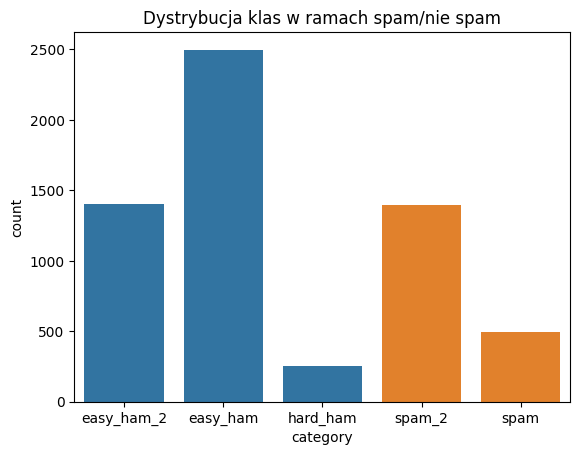

In [37]:
fig, ax = plt.subplots()
sns.countplot(df[df['spam']==0], x='category', ax=ax)
sns.countplot(df[df['spam']==1], x='category', ax=ax)
ax.set_title('Dystrybucja klas w ramach spam/nie spam')

In [45]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


In [46]:
df['mail'] = df['mail'].apply(preprocess_text)

In [48]:
X = vec.fit_transform(df["mail"])

X_train, X_test, y_train, y_test = train_test_split(X, df['spam'], test_size=0.2, random_state=42)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9801324503311258
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       824
           1       0.98      0.96      0.97       384

    accuracy                           0.98      1208
   macro avg       0.98      0.98      0.98      1208
weighted avg       0.98      0.98      0.98      1208



In [49]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Disable label encoding warnings
xgb_classifier.fit(X_train.toarray(), y_train)  # Convert sparse matrix to dense for XGBoost compatibility
y_pred_xgb = xgb_classifier.predict(X_test.toarray())

print("XGBoost Classifier Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

/Users/mszawerda/25L-zum/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:12:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Accuracy: 0.9942052980132451
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       824
           1       0.99      0.99      0.99       384

    accuracy                           0.99      1208
   macro avg       0.99      0.99      0.99      1208
weighted avg       0.99      0.99      0.99      1208

